## Import packages

In [1]:
#import os                        # operating system (creation-deletion files and folders)
from os import remove
import sys
import numpy as np               # arrays and mathematical operations
import matplotlib.pyplot as plt  # plotting
sys.path.insert(0, '..')
from pybandstructure import *

In [2]:
dir()

['Band_Structure',
 'Crystal',
 'Crystal_Geometry',
 'In',
 'Momentum_Conserving_Operator',
 'Operator',
 'Out',
 'Point_Group',
 'Sample',
 'Selector',
 'Space_Sample',
 'Unit_Cell_Sample',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i2',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'analysis',
 'band_structure',
 'bose_function',
 'build_basis_matrix',
 'build_density_operator',
 'build_kinetic_hamiltonian',
 'build_kinetic_term',
 'build_matrix_from_block',
 'build_potential_hamiltonian',
 'build_potential_term',
 'common',
 'conjugate_function',
 'crystal',
 'crystal_geometry',
 'delta_function',
 'dirac',
 'exit',
 'fermi_function',
 'geometry',
 'get_ipython',
 'koshino',
 'lin',
 'maxwell_function',
 'models',
 'multiply_function_scalar',
 'multiply_functions',
 'np',
 'operators',
 'pauli_matrix',
 'plt',
 'point_groups',
 'quit',
 'reflection_matrix',
 'remove',
 'rotation_matrix',
 '

## Graphene parameters

$$ {\cal H}({\bf k}) = \hbar v_{\rm F}[\sigma_x k_x + \sigma_y k_y ]+ \Delta \,\sigma_z$$

In [3]:
#distances in nm, energies in eV
hv_F = 0.658   # \hbar v_F in eV*nm
delta = 0.000  # gap in eV

## Sampling of reciprocal space
We use a square sampling in the region $$-k_{cutoff} \leq k_x \leq k_{cutoff}$$ $$-k_{cutoff} \leq k_y \leq k_{cutoff}$$

with $n_{sites} \times n_{sites}$ points

In [4]:
k_cutoff = 2. #nm^-1 energies are accurate up to +-hv_F * k_cutoff
n_sites = 101 # integer, better if odd
print('E_max = ',hv_F * k_cutoff)
print('Energy_resolution = ', hv_F * k_cutoff /n_sites)

E_max =  1.316
Energy_resolution =  0.01302970297029703


Points are stored as rational coordinates with respect to a basis in the form
$$k(n_1,n_2) = {\bf G}_1 \frac{n_1}{n_{sites}} + {\bf G}_2 \frac{n_2}{n_{sites}}$$

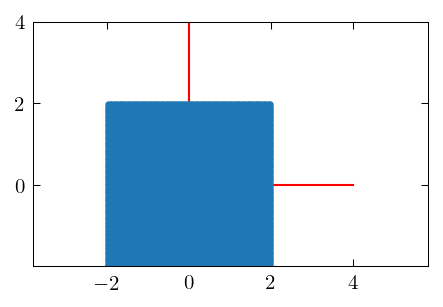

In [5]:
reciprocal_lattice_basis = 2 * k_cutoff * np.array([[1.,0.],
                                                    [0.,1.]])

k_sample = sample.Space_Sample.cubic_sample(basis_vectors = reciprocal_lattice_basis, 
                                            denominator = n_sites)
k_sample.plot()

## Define point group
Point group (set of rotation and reflections that leave the lattice unchanged)

Use of symmetry reduces the number of calculations needed

In [6]:
point_group = Point_Group.trivial_group(space_dimension = 2)  #trivial group (group with only the identity operation)
point_group2 = Point_Group.dihedral_group(n=6)

## Define crystal geometry 
Contains all the geometrical information about the lattice (lattice and symmetry group)

In [7]:
lattice_geometry = Crystal_Geometry(reciprocal_lattice_basis = reciprocal_lattice_basis, 
                                    point_group = point_group)

## Define Hamiltonian 

$$ {\cal H}({\bf k}) = \hbar v_{\rm F}[\sigma_x k_x + \sigma_y k_y ]+ \Delta \,\sigma_z$$


Operators are defined as linear combinations of matrices and coefficients

$$ O({\bf k}) = \sum_j f_j({\bf k}) M^{(j)}$$


In [8]:
H_Dirac = hv_F * Momentum_Conserving_Operator(matrices = [pauli_matrix('x'), pauli_matrix('y')],
                                        coefficients = [lambda k : k[0], lambda k : k[1]]) 

H_gap = Momentum_Conserving_Operator(matrices = [pauli_matrix('z')],
                                     coefficients = [delta]) 
H = H_Dirac + H_gap

## Define momentum operator

$$ p_i({\bf k}) = \partial_{k_i} {\cal H}({\bf k}) $$ 

In [9]:
p_x = Momentum_Conserving_Operator(matrices = [pauli_matrix('x'), pauli_matrix('y')],
                                   coefficients =[hv_F ,0])
p_y = Momentum_Conserving_Operator(matrices = [pauli_matrix('x'), pauli_matrix('y')],
                                   coefficients = [0,hv_F ])

## Initialize band structure

In [10]:
################### these parameters can be changed later ##############
density = 0. # nm^-2
temperature = 0.026 # k_B T in eV
eta = 0.020 # eV energy broadening \hbar/tau 
########################################################################
#initialization
band_structure = Band_Structure.from_hamiltonian(k_sample = k_sample,
                                                 hamiltonian = H, 
                                                 momentum_operator= [p_x,p_y],
                                                 degeneracy = 4,
                                                 zero_filling = 1,
                                                 density = density,
                                                 temperature = temperature)

## Calculate band structure

In [11]:
f_name = '../notebooks/test_output/test_band_structure.hdf5'
try:
    remove(f_name)
except:
    pass

In [12]:
band_structure.compute_bands()
band_structure.compute_momentum_matrix()
print(band_structure.chemical_potential)

100%|█████████████████████████████████████████████████████████████████████████| 10201/10201 [00:00<00:00, 17289.74it/s]

0.0


## Plot band structure along a contour

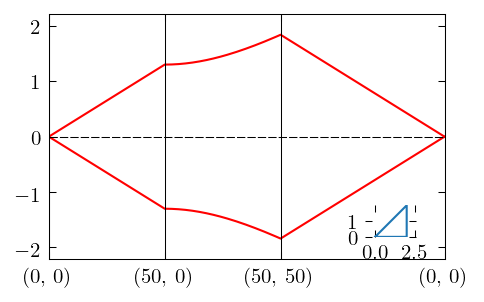

In [13]:
contour = [(0,0),(n_sites//2,0),(n_sites//2,n_sites//2),(0,0)]
band_structure.plot(contour, c='r')
ax = plt.axes([0.80,0.25,0.10,0.10], frameon = False)
plt.axis('equal')
plt.plot([k_sample.get_coords(x)[0] for x in contour],[k_sample.get_coords(x)[1] for x in contour])

## Define crystal

In [14]:
graphene = Crystal(geometry = lattice_geometry,
                   band_structure = band_structure, 
                   eta = eta)

## Plot density of states 
compare with analitical formula 
$$ DOS(E) = \frac{2|E|}{\pi \hbar^2 v_{\rm F}^2}$$

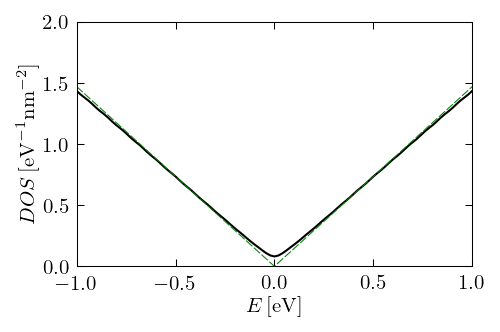

In [15]:
plt.xlabel(r'$E \, [{\rm eV}]$')
plt.ylabel(r'$DOS \, [{\rm eV}^{-1}{\rm nm}^{-2}]$')
plt.ylim(0,2)
energies = np.linspace(-1.,1., num = 101)
plt.plot(energies, graphene.dos(energies), 'k') 
plt.plot(energies, 2 *abs(energies)/ (np.pi * hv_F**2),'--', c='g', lw=0.5)

## Plot density as a function of chemical potential
compare with analitical formula (at $T=0$) 
$$ n(\mu) = \frac{sign(\mu)\mu^2}{\pi \hbar^2 v_{\rm F}^2}$$

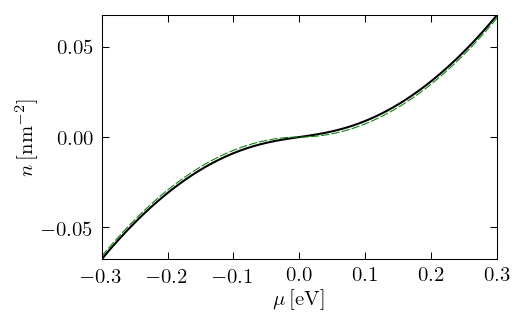

In [16]:
plt.xlabel(r'$\mu \, [{\rm eV}]$')
plt.ylabel(r'$n\, [{\rm nm}^{-2}]$')
mu_vals = np.linspace(-0.3,0.3, num = 100)
density_vals = np.array([graphene.band_structure.compute_density(chemical_potential = mu,temperature=graphene.band_structure.temperature) for mu in mu_vals])

plt.plot(mu_vals, density_vals, c= 'k')
plt.plot(mu_vals, np.sign(mu_vals) * mu_vals**2/(np.pi * hv_F**2),'--', c='g', lw=0.5)

## Theromoelectric quantities (In the relaxation time approximation)
Drude weight and dc conductivity
$$\sigma_0 = \frac{{\cal D}\tau}{\pi}$$
Thermal (electronic) conductivity
$$\kappa_0 = \sigma_0 T {\cal L} $$
Wiedemann-Franz law
$${\cal L} = {\cal L}_0 =\frac{\pi^2k_{\rm B}^2}{3e^2}$$

In [17]:
W0 = graphene.generalized_drude_weight(chemical_potential = mu_vals,exponent=0)[:,0,0]
W1 = graphene.generalized_drude_weight(chemical_potential = mu_vals,exponent=1)[:,0,0]
W2 = graphene.generalized_drude_weight(chemical_potential = mu_vals,exponent=2)[:,0,0]

lorentz_number = 3./(np.pi**2* graphene.band_structure.temperature**2)*W2/W0
seebeck = -W1/(W0 * graphene.band_structure.temperature)

## Drude weight
Compare with the $T=0$ formula
$$ {\cal D}= |\mu| e^2/\hbar^2$$

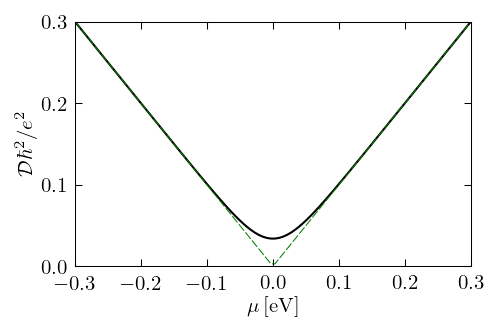

In [18]:
plt.xlabel(r'$\mu \, [{\rm eV}]$')
plt.ylabel(r'${\cal D}\hbar^2/e^2$')
plt.ylim(0,np.amax(W0))

plt.plot(mu_vals,W0,'k-')
plt.plot(mu_vals,abs(mu_vals),'g--',lw=0.5)

## Seebeck coefficient
Compare with Mott's formula (black-dashed) and with the Fermi-liquid result (green)
$$S = -\frac{\pi^2k_{\rm B}^2 T }{3e\mu}$$

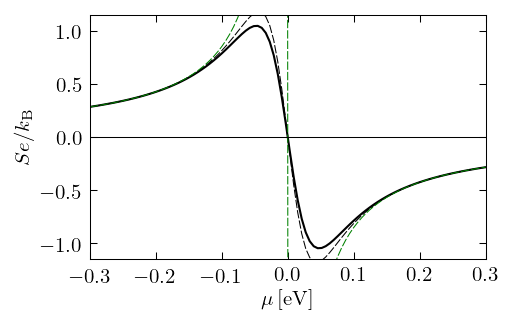

In [19]:
plt.xlabel(r'$\mu \, [{\rm eV}]$')
plt.ylabel(r'$Se/k_{\rm B}$')
plt.ylim(-np.amax(seebeck)*1.1,np.amax(seebeck)*1.1)

plt.plot(mu_vals,seebeck,'k-')
plt.plot(mu_vals,-np.pi**2/3 * graphene.band_structure.temperature*np.gradient(W0,mu_vals)/W0,'k--',lw=0.5)
plt.plot(mu_vals,-np.pi**2/3 * graphene.band_structure.temperature/mu_vals,'g--',lw=0.5)
plt.plot(mu_vals,np.zeros_like(mu_vals),'k-',lw=0.5)

## Lorentz ratio
Compare with the Wiedemann-Franz law
$$\frac{{\cal L}}{{\cal L}_0} = 1 $$

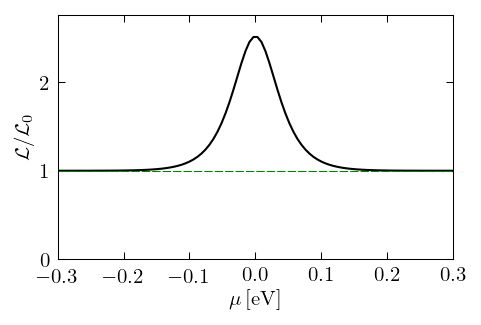

In [20]:
plt.ylabel(r'${\cal L}/{\cal L}_0$')
plt.xlabel(r'$\mu \, [{\rm eV}]$')
plt.ylim(0,np.amax(lorentz_number)*1.1)

plt.plot(mu_vals, lorentz_number, 'k-')
plt.plot(mu_vals, np.ones_like(mu_vals),'g--',lw=0.5)

## Calculate conductivity

In [21]:
omega_vals = np.linspace(0,1, num = 100)
sigma_vals = graphene.local_conductivity(omega_vals) # result in units of G_0, the quantum of conductance

..\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


## Plot conductivity
Interband conductivity conveges to $$\sigma_{\rm uni } = \frac{\pi G_0}{4 } = \frac{\pi e^2}{2 h} = \frac{e^2}{4\hbar}$$

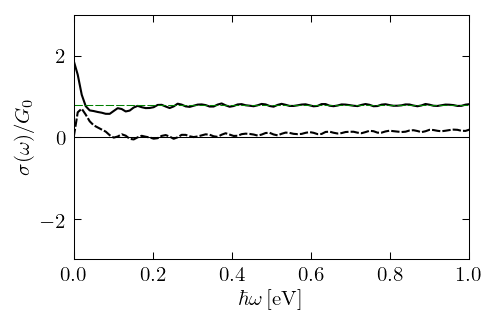

In [22]:
plt.xlabel(r'$\hbar \omega \, [{\rm eV}]$')
plt.ylabel(r'$\sigma(\omega)/G_0$')
plt.ylim(-3,3)
plt.plot(omega_vals,np.real(sigma_vals[:,0,0]),c='k') #note that sigma is a matrix, here I am selecting the xx component
plt.plot(omega_vals,np.imag(sigma_vals[:,0,0]),'--',c='k')

plt.plot(omega_vals,np.ones_like(omega_vals)*np.pi/4,'--', c='g', lw=0.5)
plt.plot(omega_vals,np.zeros_like(omega_vals),'k-',lw=0.5)

## Dynamically change density, chemical potential or temperature

0.25648784734788066


..\pybandstructure\band_structure\band_structure.py:581: UserWarning: changing density without changing band structure
  warn("changing density without changing band structure")


([[<matplotlib.lines.Line2D at 0x23e23647e48>],
 [[<matplotlib.lines.Line2D at 0x23e23653f48>],
 [<matplotlib.lines.Line2D at 0x23e23653e08>])

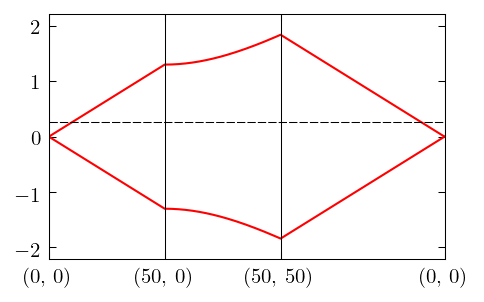

In [23]:
graphene.band_structure.density = 0.05
print(graphene.band_structure.chemical_potential)
graphene.band_structure.plot(contour, c='r')

## Recalculate optical conductivity

Conductivity is redistributed due to Pauli blocking effect

..\pybandstructure\crystal\analysis\conductivity_functions.py:8: RuntimeWarning: invalid value encountered in true_divide
  prefactor = -occupation_diff / energy_diff


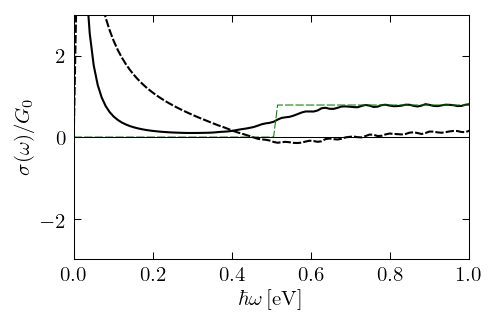

In [24]:
sigma_vals = graphene.local_conductivity(omega_vals) # result in units of G_0, the quantum of conductance

plt.xlabel(r'$\hbar \omega \, [{\rm eV}]$')
plt.ylabel(r'$\sigma(\omega)/G_0$')
plt.ylim(-3,3)
plt.plot(omega_vals,np.real(sigma_vals[:,0,0]),c='k') #note that sigma is a matrix, here I am selecting the xx component
plt.plot(omega_vals,np.imag(sigma_vals[:,0,0]),'--',c='k')
plt.plot(omega_vals,np.heaviside(omega_vals-2*abs(graphene.band_structure.chemical_potential),0.5)*np.pi/4, '--',c='g', lw=0.5)

plt.plot(omega_vals,np.zeros_like(omega_vals),'k-',lw=0.5)